# Inference of flux control coefficients under limited data

In this notebook, I replicate the analysis performed by Contador *et al*, 2009 [1] with the linear-logarithmic inference framework. 
In particular, the task is to determine which flux control coefficients are constrained by a series of 5 overexpression experiments, measuring only the output flux of L-lysine

1. Contador, C. A., Rizk, M. L., Asenjo, J. A., & Liao, J. C. (2009). Ensemble modeling for strain development of l-lysine-producing Escherichia coli. Metabolic Engineering, 11(4-5), 221–233. doi:10.1016/j.ymben.2009.04.002

In [1]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'


import numpy as np
import pandas as pd
import scipy

np.random.seed(0)

import pymc as pm

import pytensor
import pytensor.tensor as T
from pytensor import sparse

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='ticks', color_codes=True, font_scale=1.2,
        rc={'legend.frameon': False})

%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Create initial guesses for the elasticity matrices and define reaction and metabolite labels

In [2]:
import cobra
import emll
from emll.test_models import models
from emll.util import create_elasticity_matrix

model, N, v_star = models['contador']()

with model:
    model.reactions.EX_glc.lower_bound = -1.243
    model.reactions.EX_lys.lower_bound = .30 * 1.243
    model.reactions.zwf.bounds = (.778, .778)

#    model.summary()

    fluxes = model.optimize().fluxes

v_star = np.abs(fluxes.values)

for rxn in model.reactions:
    rxn.bounds = (-1000, 1000)

Ex = create_elasticity_matrix(model)
Ey = np.zeros((len(model.reactions), 0))


m_labels = [m.id for m in model.metabolites]
r_labels = [r.id for r in model.reactions]

ex_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                       for mlabel in m_labels] for rlabel in r_labels]).flatten()

r_compartments = [
    list(r.compartments)[0] if len(r.compartments) == 1 else 't'
    for r in model.reactions
]

m_compartments = [
    m.compartment for m in model.metabolites
]

# Add inhibitors from Contador
# NADH inhibition of CS
# Ex[model.reactions.index('gltA'),
#         model.metabolites.index('NADH')] = -1

# Ex[model.reactions.index('pfk'),
#         model.metabolites.index('PEP')] = -1

Ex[22] = 0.  # Glucose import

Here we specify the experimental data, which consists of a series of overexpressions and resulting (assumed) differences in enzyme concentrations. Here we set the reference state as the optimal performing strain, and set each successive enzyme as a doubling of the enzyme concentration.

In [3]:
# flipped reaction order
ox_order = [
     ['dapD'],
     ['dapE'],
     ['dapD', 'dapE'],
     ['dapD', 'dapE', 'dapB'],
     ['dapD', 'dapE', 'dapB', 'lysC'],
     ['dapD', 'dapE', 'dapB', 'lysC', 'dapA']
]

strains = [
    'dapA, lysC, dapB, dapE',
    'dapA, lysC, dapB, dapD',
    'dapA, lysC, dapB',
    'dapA, lysC',
    'dapA',
    'Wild Type'
]

n_exp = len(strains)
nm, nr = N.shape
      
# Assumed 20% improvement from each doubling
ox_results = np.array([27.3, 27.2, 26.5, 22.5, 8.9, 0.2]) / 30.0
#ox_results = np.array([8.9, 0.2]) / 30.0

These are the assumed lysine flux for each strain relative to the optimal strain design.

In [4]:
# yields = np.array([27.3, 27.2, 26.5, 22.5, 8.9, 0.2]) / 30.0
# yields

In [5]:
ox_results

array([0.91      , 0.90666667, 0.88333333, 0.75      , 0.29666667,
       0.00666667])

### Create Linlog model object

In [6]:
ll = emll.LinLogLeastNorm(N, Ex, Ey, v_star, driver='gelsy')
from emll.util import initialize_elasticity

In [7]:
rxn_index = {
    'dapD': 0,
    'dapE': 1,
    'dapB': 2,
    'lysC': 3,
    'dapA': 4
}

In [8]:
np.random.seed(1)

lys_index = model.reactions.index('EX_lys')

with pm.Model() as pymc_model:
       
    Ex_t = pm.Deterministic('Ex', initialize_elasticity(
        ll.N,  b=0.05, sigma=1, alpha=None,
        m_compartments=m_compartments,
        r_compartments=r_compartments
    ))
    Ey_t = T.zeros_like(ll.Ey, dtype='float32')
    
    # We don't know the expression (here, underexpression vs. reference) of
    # each protein as a result of the plasmid integration. So, we use a
    # symbolic variable for each protein in the enzyme expression matrix.
    e_hat = T.ones((n_exp, nr))
    e_hat_entries = pm.Uniform('e_hat_entries', lower=0, upper=1, shape=(5,))
    
    for i, rxns in enumerate(ox_order):
        for rxn in rxns:
            e_hat = T.set_subtensor(
                e_hat[i, model.reactions.index(rxn)],
                e_hat_entries[rxn_index[rxn]])
            
    # Store the fitted e_hat in the trace object
    e_hat = pm.Deterministic('e_hat', e_hat)      

with pymc_model:
    trace_prior = pm.sample_prior_predictive()

Sampling: [e_hat_entries, ex_capacity_entries, ex_kinetic_entries]


In [333]:
with pymc_model:
    
    # Calculate steady-state concentrations and fluxes from elasticities
    xn, vn = ll.steady_state_pytensor(Ex_t, Ey_t, e_hat, np.ones((n_exp, ll.ny)))

    # Error distribution for observed steady-state lysine out
    lys_mean = pm.Deterministic('lys_mean', vn[:, lys_index])
    ox_result = pm.Normal('ox_result', mu=lys_mean, sigma=0.01, observed=ox_results)

#print(pymc_model.logpt.tag.test_value)

ValueError: Variable name lys_mean already exists.

In [ ]:
-1434.8237013100402

### Running ADVI inference

This is definitely the computationally intensive step (although fairly fast). Runs the ADVI optimization.
The learning rate here is a critical parameter. Definitely adjust it around until you can get the elbo as low as possible.

In [44]:
with pymc_model:
    approx = pm.ADVI(random_seed=1)
    hist = approx.fit(n=25000, obj_optimizer=pm.adagrad_window(learning_rate=0.01),
                      obj_n_mc=1)

Finished [100%]: Average Loss = 255.22


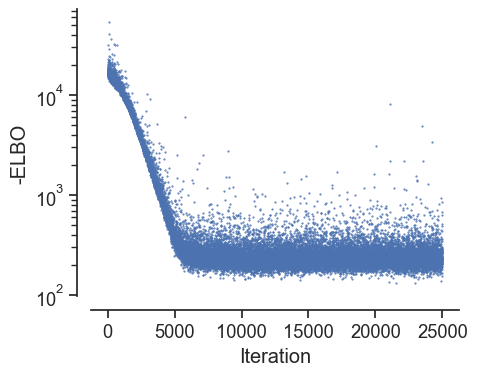

In [45]:
fig = plt.figure(figsize=(5,4))
plt.semilogy(approx.hist, '.', ms=1)
sns.despine(offset=10)

plt.ylabel('-ELBO')
plt.xlabel('Iteration')
plt.tight_layout()

# plt.savefig('contador_elbo.svg')

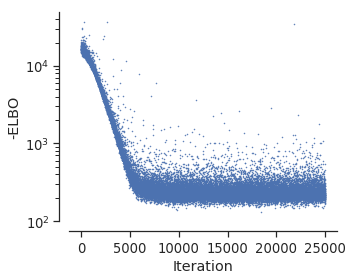

In [10]:
fig = plt.figure(figsize=(5,4))
plt.semilogy(approx.hist, '.', ms=1)
sns.despine(offset=10)

plt.ylabel('-ELBO')
plt.xlabel('Iteration')
plt.tight_layout()

# plt.savefig('contador_elbo.svg')

/Users/mcna892/mambaforge/envs/emll_dev/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'ex_capacity_entries'}>,
        <Axes: title={'center': 'ex_capacity_entries'}>],
       [<Axes: title={'center': 'ex_kinetic_entries'}>,
        <Axes: title={'center': 'ex_kinetic_entries'}>],
       [<Axes: title={'center': 'e_hat_entries'}>,
        <Axes: title={'center': 'e_hat_entries'}>],
       [<Axes: title={'center': 'Ex'}>, <Axes: title={'center': 'Ex'}>],
       [<Axes: title={'center': 'e_hat'}>,
        <Axes: title={'center': 'e_hat'}>],
       [<Axes: title={'center': 'lys_mean'}>,
        <Axes: title={'center': 'lys_mean'}>]], dtype=object)

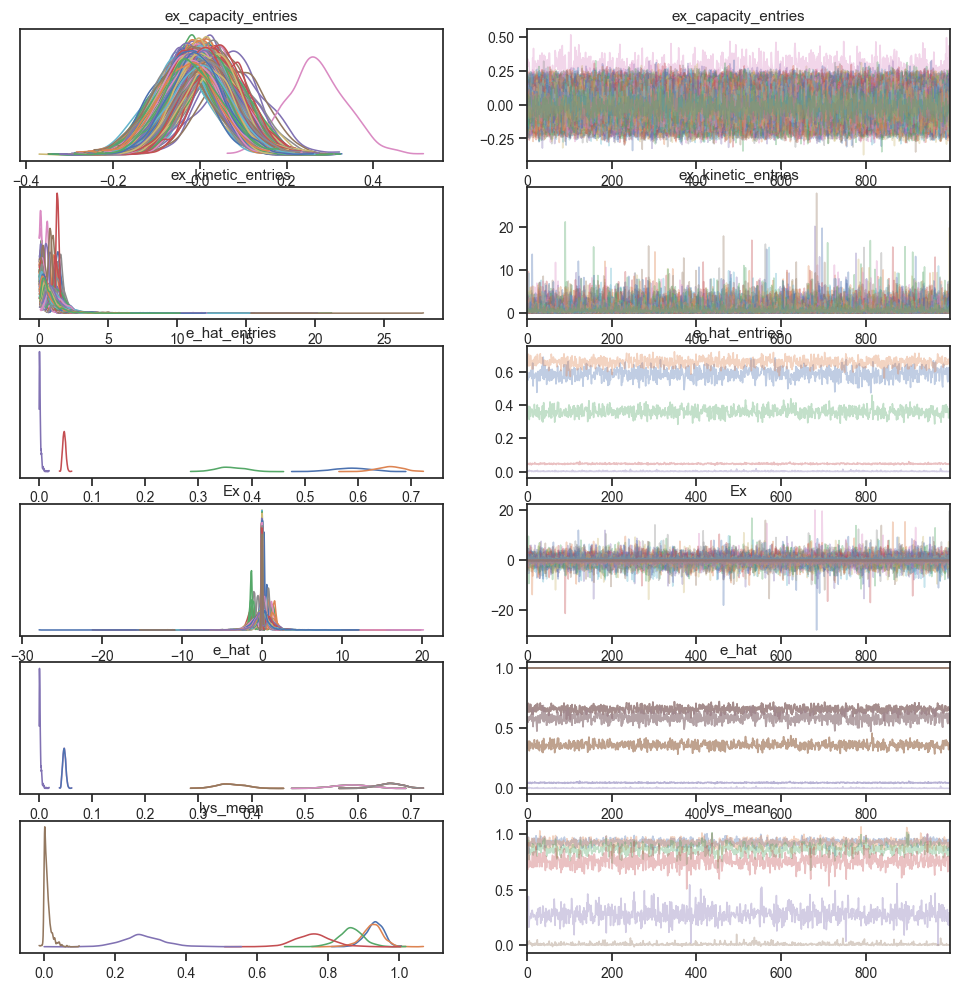

In [88]:
az.plot_trace(trace_vi)

In [121]:
with pymc_model:
    trace_vi = hist.sample(1000)
    prior_vi = pm.sample_prior_predictive(samples=1000)
    ppc_vi = pm.sample_posterior_predictive(trace_vi)

Sampling: [e_hat_entries, ex_capacity_entries, ex_kinetic_entries, ox_result]
Sampling: [ox_result]


In [104]:
ppc_vi.posterior_predictive['ox_result'].mean()

<xarray.DataArray 'ox_result' ()>
array(0.6284052)

In [117]:
trace_vi.posterior['e_hat_entries'].mean()

<xarray.DataArray 'e_hat_entries' ()>
array(0.33163436)

Plot the posterior predictive distributions in the estimated lysine flux, which shows that the estimated kinetic parameters closely reproduce the overexpression rankings

In [122]:
prior_vi

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [123]:
prior_vi.prior['lys_mean']

<xarray.DataArray 'lys_mean' (chain: 1, draw: 1000, lys_mean_dim_0: 6)>
array([[[ 0.94447039,  0.98139465,  0.92778089,  0.92461055,
          0.92486077,  0.91486341],
        [ 0.99720593,  1.00078583,  0.99799864,  0.99346305,
          0.69571861,  0.6957866 ],
        [ 0.75191929,  0.97203444,  0.73213757,  0.73502472,
          0.7408329 ,  0.73849617],
        ...,
        [ 1.03653495,  0.15153488,  0.15334551,  0.12882234,
          0.12882364,  0.12941055],
        [ 0.96500829,  0.9451516 ,  0.90448699, -0.00185369,
         -0.00202869, -0.00224678],
        [ 0.99143232,  0.97566797,  0.96704591,  0.15681829,
          0.1563555 ,  0.04741241]]])
Coordinates:
  * chain           (chain) int64 0
  * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * lys_mean_dim_0  (lys_mean_dim_0) int64 0 1 2 3 4 5

In [138]:
trace_vi.posterior['lys_mean'][:,0]

<xarray.DataArray 'lys_mean' (chain: 1, lys_mean_dim_0: 6)>
array([[0.87297958, 0.9726466 , 0.85322171, 0.68986253, 0.30972174,
        0.00466252]])
Coordinates:
  * chain           (chain) int64 0
    draw            int64 0
  * lys_mean_dim_0  (lys_mean_dim_0) int64 0 1 2 3 4 5

In [162]:
pm.hdi(trace_vi, var_names='lys_mean',hdi_prob = 0.94).as_numpy()

<xarray.Dataset>
Dimensions:         (lys_mean_dim_0: 6, hdi: 2)
Coordinates:
  * lys_mean_dim_0  (lys_mean_dim_0) int64 0 1 2 3 4 5
  * hdi             (hdi) <U6 'lower' 'higher'
Data variables:
    lys_mean        (lys_mean_dim_0, hdi) float64 0.8822 0.9766 ... 0.03654

In [150]:
trace_vi.posterior['lys_mean'][:,1].mean()

<xarray.DataArray 'lys_mean' ()>
array(0.60689087)
Coordinates:
    draw     int64 1

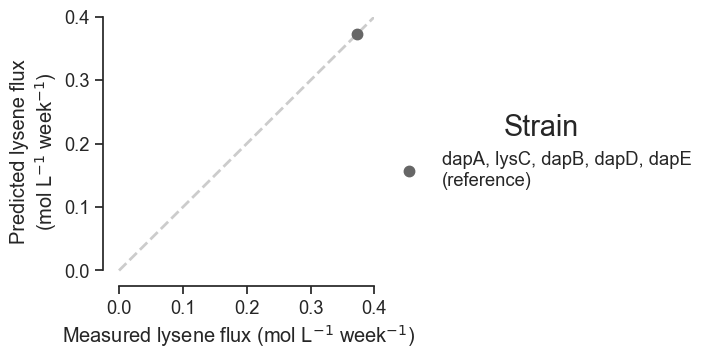

In [149]:
fig = plt.figure(figsize=(3.5,3.5))
ax = fig.add_subplot(111)

for i in range(n_exp):
    
    #hpd = pm.hpd(trace_vi['lys_mean'][:, i]) * v_star[lys_index]
    mean = trace_vi.posterior['lys_mean'][:, i].mean() * v_star[lys_index]
    #ax.errorbar(ox_results[i] * v_star[lys_index], mean,
    #            yerr=np.atleast_2d([mean-hpd[0], hpd[1]-mean]).T, marker='o',
    #            label=strains[i], capsize=4, capthick=2, ls='none', ms=7.5)
    
ax.plot(v_star[lys_index], v_star[lys_index], 'o', color='.4', ms=7.5,
        label='dapA, lysC, dapB, dapD, dapE\n(reference)')

legend = ax.legend(loc='center left', bbox_to_anchor=(1., .5), title='Strain')
plt.setp(legend.get_title(),fontsize='x-large')

ax.plot([0, .4], [0, .4], ls='--', color='.8', zorder=0, lw=2)

ax.set_xlabel('Measured lysene flux (mol L$^{-1}$ week$^{-1}$)')
ax.set_ylabel('Predicted lysene flux\n(mol L$^{-1}$ week$^{-1}$)')

ax.set_xlim((-0.025, 0.4))
ax.set_ylim((-0.025, 0.4))

ax.set_xticks([0, .1, .2, .3, .4])

sns.despine(trim=True)
fig.savefig('lysine_flux_prediction.svg')

In [15]:
# fig = plt.figure()
# ax = fig.add_subplot(111)

# ax.axvline(1, lw=2.5, color='.4', label='dapA, lysC, dapB, dapD, dapE\n(reference)', ls='--')

# for amount in ox_results:
#     ax.axvline(amount, lw=2.5, color='.4', ls='--')

# for i in range(n_exp): 
#     pm.kdeplot(trace_vi['lys_mean'][:, i], shade=.1, ax=ax, label=strains[i])
    
    
# legend = ax.legend(loc='center left', bbox_to_anchor=(1., .5), title='Strain')
# plt.setp(legend.get_title(),fontsize='x-large')

# ax.set_ylabel('Frequency')
# ax.set_xlabel('Lysene flux (relative to reference)')

# sns.despine(offset=10)

# ax.set_xlim([-.2, 1.6])
# ax.set_ylim([0, 25])

# # fig.tight_layout()
# sns.despine(trim=True)
# # fig.savefig('sequential_ox.svg', transparent=True)

Re-index the elasticity values for a boxplot

In [163]:
e_guess = -N.T
e_flat = e_guess.flatten()
nonzero_inds = np.where(e_flat != 0)[0]
zero_inds = np.where(e_flat == 0)[0]
e_sign = np.sign(e_flat[nonzero_inds])
flat_indexer = np.hstack([nonzero_inds, zero_inds]).argsort()

In [200]:
(np.diff(pm.hdi(trace_vi.posterior['ex_kinetic_entries']).to_array().to_numpy()[0])<0.75).flatten()

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [212]:
(trace_vi.posterior['ex_kinetic_entries'] * e_sign)[0][:,identifiable_elasticies]

<xarray.DataArray 'ex_kinetic_entries' (draw: 1000, ex_kinetic_entries_dim_0: 5)>
array([[ 0.57436402, -1.10251658, -0.493904  ,  0.85750221, -1.37083595],
       [ 0.61149551, -0.84417232, -0.67857624,  0.83383369, -1.40543084],
       [ 0.91430923, -0.98747922, -0.68543569,  0.95594073, -1.16949125],
       ...,
       [ 0.61251448, -0.69959635, -0.82036618,  0.81803988, -1.57856282],
       [ 0.53459644, -1.35884861, -0.52543565,  0.79884693, -1.56581768],
       [ 0.68372977, -1.016534  , -0.53038993,  0.75288085, -1.45715165]])
Coordinates:
    chain                     int64 0
  * draw                      (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * ex_kinetic_entries_dim_0  (ex_kinetic_entries_dim_0) int64 6 15 24 25 63

In [213]:
identifiable_elasticies = (np.diff(pm.hdi(trace_vi.posterior['ex_kinetic_entries']).to_array().to_numpy()[0]) < .75).flatten()

mlabels = [m.id for m in model.metabolites]
rlabels = [r.id for r in model.reactions]

e_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                      for mlabel in mlabels] for rlabel in rlabels]).flatten()

elast_nonzero = pd.DataFrame((trace_vi.posterior['ex_kinetic_entries'] * e_sign)[0][:, identifiable_elasticies],
                             columns=e_labels[nonzero_inds][identifiable_elasticies])

In [222]:
pm.hdi(trace_vi.posterior['ex_capacity_entries']).to_array().to_numpy()[0]

array([[-0.11057099,  0.13758857],
       [-0.11373711,  0.14987554],
       [-0.1145385 ,  0.10944272],
       ...,
       [-0.13018893,  0.13263898],
       [-0.16366751,  0.10009432],
       [-0.15056661,  0.11025869]])

In [223]:
null = pd.DataFrame(pm.hdi(trace_vi.posterior['ex_capacity_entries']).to_array().to_numpy()[0])
sig = np.sign(null)[0] == np.sign(null)[1]
sum(sig)

1

In [238]:
elast_zero = pd.DataFrame(trace_vi.posterior['ex_capacity_entries'][0][:, sig], columns=e_labels[zero_inds[sig]])
elast_posterior = elast_nonzero.iloc[:, elast_nonzero.mean().argsort()].join(elast_zero)

In [245]:
elast_prior = pd.DataFrame(
    trace_prior.prior['Ex'].to_numpy().reshape(500, -1), columns=e_labels
).reindex(columns=elast_posterior.columns)

/Users/mcna892/mambaforge/envs/emll_dev/lib/python3.11/site-packages/seaborn/categorical.py:691: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/Users/mcna892/mambaforge/envs/emll_dev/lib/python3.11/site-packages/seaborn/categorical.py:691: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/Users/mcna892/mambaforge/envs/emll_dev/lib/python3.11/site-packages/seaborn/categorical.py:691: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/Users/mcna892/mambaforge/envs/emll_dev/lib/python3.11/site-packages/seaborn/categorical.py:691: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/Users/mcna892/mambaforge/envs/emll_dev/lib/python3.11/site-packages/seaborn/categorical.py:691:

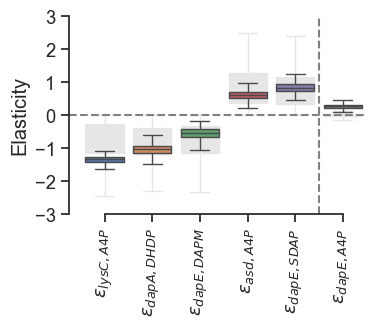

In [247]:
fig = plt.figure(figsize=(4, 3.5))
ax = fig.add_subplot(111)

_ = sns.boxplot(data=elast_posterior, fliersize=0, ax=ax, zorder=2)
_ = sns.boxplot(data=elast_prior, fliersize=0, zorder=0, showmeans=False,
                 capprops=dict(color='.9', zorder=0), medianprops=dict(color='.9', zorder=0.5),
                 whiskerprops=dict(color='.9', zorder=0), boxprops=dict(color='.9', facecolor='w', zorder=0), ax=ax)


_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.axhline(0, ls='--', color='.5', zorder=1)
ax.axvline(elast_nonzero.shape[1] - .5, color='.5', ls='--')

ax.set_ylabel('Elasticity')
sns.despine(trim=True)

ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
ax.set_ylim([-3, 3])


ax.set_xlim(-.75, elast_nonzero.shape[1] + elast_zero.shape[1] - .5)
sns.despine(ax=ax, trim=True)

#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(18) 

plt.tight_layout()
plt.savefig('contador_elasticities.svg')

In [260]:
fcc = pd.DataFrame(np.array([ll.flux_control_coefficient(Ex=trace_vi.posterior['Ex'].to_numpy()[0][i])[lys_index]
                             for i in range(len(trace_vi))]),
                   columns=[r.id for r in model.reactions])

fcc_prior = pd.DataFrame(np.array([ll.flux_control_coefficient(
    Ex=trace_prior.prior['Ex'].to_numpy()[0][i])[lys_index]
                                   for i in range(len(trace_prior))]),
                   columns=[r.id for r in model.reactions])

# Calculate the fcc values that have 95% Highest Posterior Densities with a consistent direction.
hpd = pm.hdi(fcc.values)
fcc_consistent = np.sign(hpd[:, 0]) == np.sign(hpd[:, 1])

/var/folders/1f/ksln774x1hd1pzfgsjgpxt7r0000gn/T/ipykernel_1270/1992961337.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hpd = pm.hdi(fcc.values)


In [282]:
col.median()

-0.209393058657571

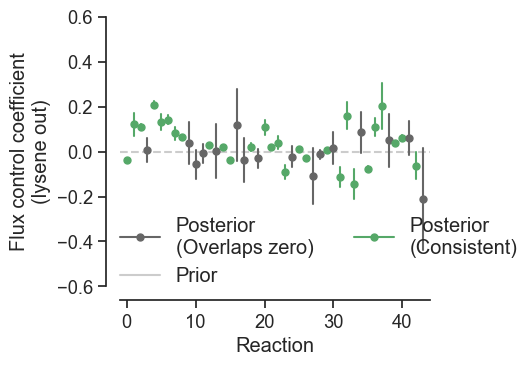

In [283]:
fig = plt.figure(figsize=(4, 3.5))
ax = fig.add_subplot(111)

for i, (name, col) in enumerate(fcc.items()):
    
    if name in fcc.columns[fcc_consistent]:
        color='g'
    
        l_g = ax.plot([i, i], pm.hdi(col.to_numpy()), color=color)
        dot_g = ax.plot(i, col.median(), '.', color=color, ms=10)

    else:
        color='.4'
    
        l_4 = ax.plot([i, i], pm.hdi(col.to_numpy()), color=color)
        dot_4 = ax.plot(i, col.median(), '.', color=color, ms=10)
    
    l_p = ax.plot([i, i], pm.hdi(fcc_prior[name].to_numpy()), color='.8', zorder=0)
    


ax.axhline(0, ls='--', color='.8', zorder=0)

#ax.set_ylim([-5E-5, 1E-4])
# ax.set_xlim([-1, 16])

plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax.set_ylabel('Flux control coefficient\n(lysene out)')

ax.set_xlabel('Reaction')

plt.legend(((l_4[0], dot_4[0]), l_p[0], (l_g[0], dot_g[0])),
           ('Posterior\n(Overlaps zero)',  'Prior', 'Posterior\n(Consistent)',),
           borderaxespad=0, borderpad=0, ncol=2, fontsize='medium')


xs = np.where(fcc_consistent)[0]
ys = fcc.loc[:, fcc_consistent].mean(0).values
labels = fcc.columns[fcc_consistent]

plt.ylim([-.6, .6])
plt.xlim([-1, ll.nr])

#ax.set_xticks([0, 10, 20, 30, 40, 45])

#plt.tight_layout()

sns.despine(trim=False, offset=10)
plt.savefig('fccs_contador.svg', transparent=True)

In [284]:
fcc.columns[fcc_consistent]

Index(['acn', 'argD', 'asd', 'dapA', 'dapB', 'dapD', 'dapE', 'dapF', 'fum',
       'gdhA', 'gltA', 'icd', 'lysC', 'EX_lys', 'EX_glc', 'mdh', 'pfk', 'pgi',
       'ppc', 'recATP', 'recNADH', 'recNADPH', 'rpi', 'sdh', 'sucAB', 'tal',
       'tka1', 'tpi'],
      dtype='object')

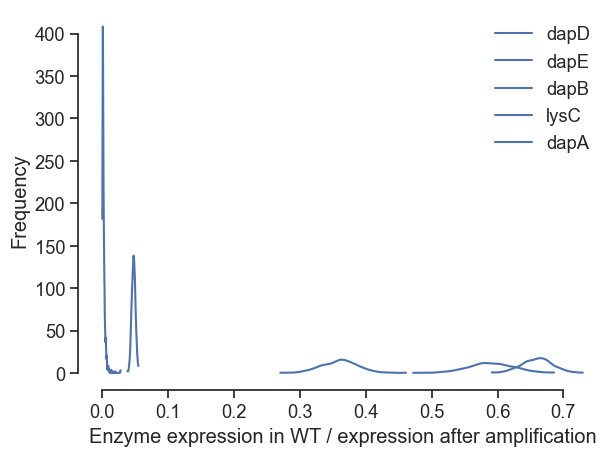

In [323]:
fig = plt.figure()
ax = fig.add_subplot(111)
colors = sns.color_palette("hls", len(rxn))

for rxn, index in rxn_index.items():
    pm.plot_kde(trace_vi.posterior['e_hat_entries'].to_numpy()[0][:, index], ax=ax, label=rxn, fill_kwargs={"facecolor": cm.viridis(np.linspace(0, 1, num=trace_vi.posterior['e_hat_entries'].to_numpy()[0][:, index].shape[0]))})
plt.legend(loc='upper right')
plt.ylabel('Frequency')
plt.xlabel('Enzyme expression in WT / expression after amplification')

sns.despine(trim=True)
plt.tight_layout()
plt.savefig('posterior_enzyme_expression.svg')

In [321]:
from matplotlib import cm

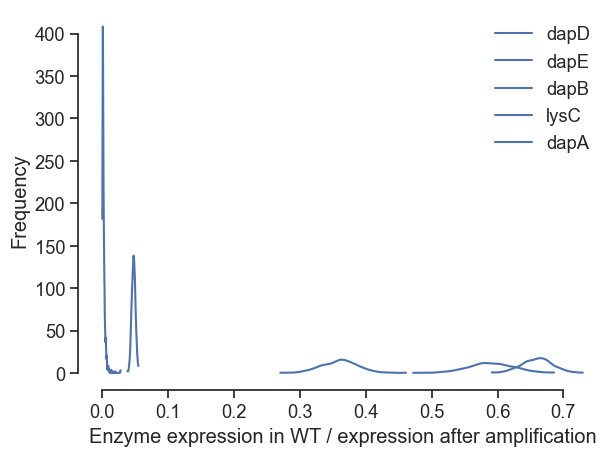

In [332]:
# Create a list of colormaps
colormaps = [cm.viridis, cm.coolwarm,cm.coolwarm, cm.inferno, cm.inferno]

fig, ax = plt.subplots()

for i, (rxn, index) in enumerate(rxn_index.items()):
    # Use a different colormap for each plot
    pm.plot_kde(
        trace_vi.posterior["e_hat_entries"].to_numpy()[0][:, index],
        ax=ax,
        label=rxn,
    )

plt.legend(loc="upper right")
plt.ylabel("Frequency")
plt.xlabel("Enzyme expression in WT / expression after amplification")
sns.despine(trim=True)
plt.tight_layout()